#Introduction

Trying to implement attention -> fist attempt quite good

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge2_Mio

/gdrive/MyDrive/Challenge2_Mio


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=cf8ef12ad0928b3422b822af013d42f89852bd101f06f6269d6cf4a22c475c91
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Attention_v1_' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


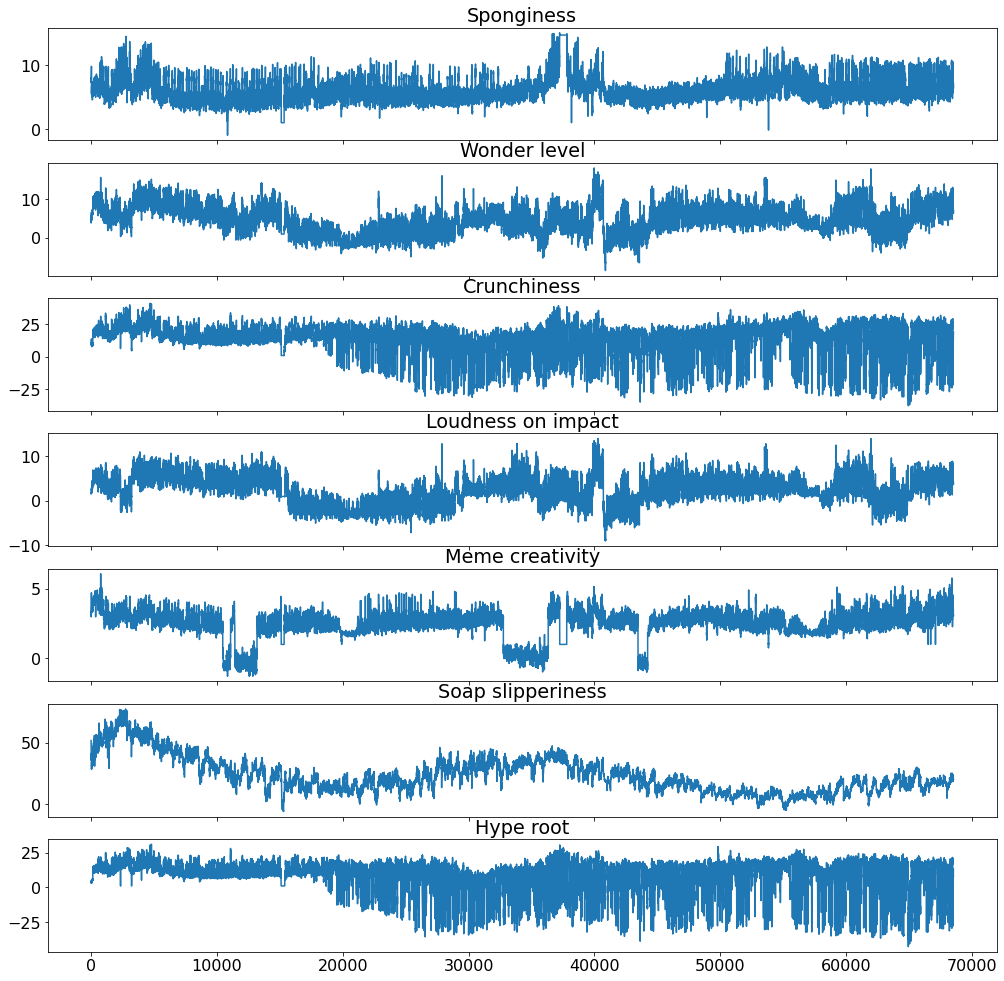

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


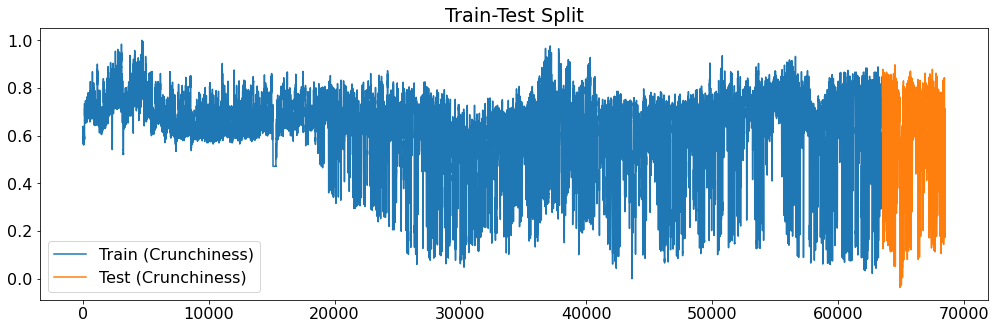

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
# Parameters for window and stride

ar_window = 250
ar_stride = 10
general_telescope = 864

In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    print(lstm.shape)
    # Implemented the self-attention using the layer from the library we imported above
    
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    print(attention.shape)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

# Multivariate Forecasting

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6264, 250, 7), (6264, 864, 7), (389, 250, 7), (389, 864, 7))

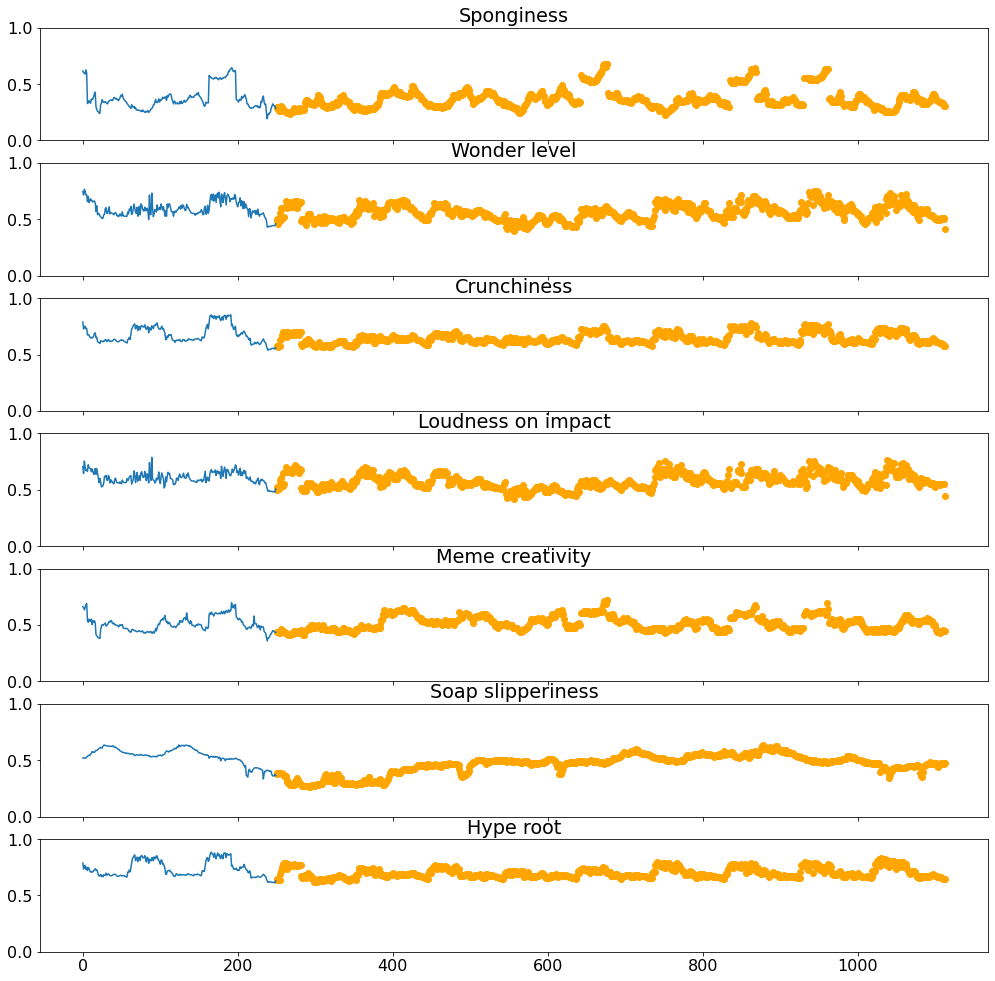

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 500

In [ ]:
print(input_shape, output_shape)

(250, 7) (864, 7)


(None, 250, 512)
(None, 250, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 250, 7)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 250, 512)         540672    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 250, 512)         32833     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 512)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6048)              3102624   
                           

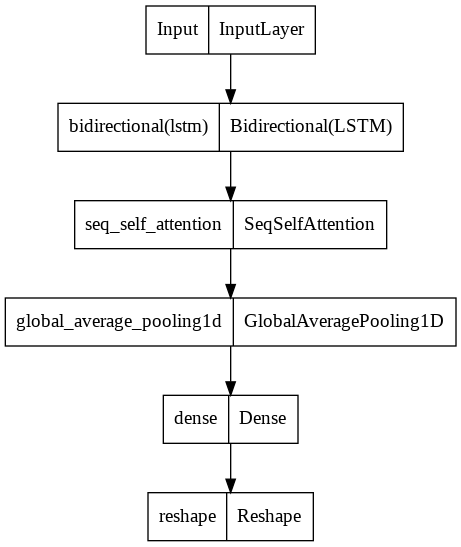

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
88/89 [============================>.] - ETA: 0s - loss: 0.1069 - mae: 0.2385 - rmse: 0.3270

89/89 [==============================] - 40s 348ms/step - loss: 0.1069 - mae: 0.2385 - rmse: 0.3270 - val_loss: 0.0901 - val_mae: 0.2149 - val_rmse: 0.3001 - lr: 0.0010
Epoch 2/500
88/89 [============================>.] - ETA: 0s - loss: 0.0844 - mae: 0.1980 - rmse: 0.2905

89/89 [==============================] - 30s 336ms/step - loss: 0.0844 - mae: 0.1980 - rmse: 0.2905 - val_loss: 0.0726 - val_mae: 0.1807 - val_rmse: 0.2695 - lr: 0.0010
Epoch 3/500
88/89 [============================>.] - ETA: 0s - loss: 0.0665 - mae: 0.1659 - rmse: 0.2579

89/89 [==============================] - 29s 331ms/step - loss: 0.0665 - mae: 0.1659 - rmse: 0.2579 - val_loss: 0.0618 - val_mae: 0.1638 - val_rmse: 0.2486 - lr: 0.0010
Epoch 4/500
88/89 [============================>.] - ETA: 0s - loss: 0.0586 - mae: 0.1522 - rmse: 0.2421

89/89 [==============================] - 30s 334ms/step - loss: 0.0586 - mae: 0.1522 - rmse: 0.2421 - val_loss: 0.0575 - val_mae: 0.1559 - val_rmse: 0.2398 - lr: 0.0010
Epoch 5/500
88/89 [============================>.] - ETA: 0s - loss: 0.0509 - mae: 0.1395 - rmse: 0.2257

89/89 [==============================] - 29s 332ms/step - loss: 0.0509 - mae: 0.1395 - rmse: 0.2257 - val_loss: 0.0510 - val_mae: 0.1478 - val_rmse: 0.2258 - lr: 0.0010
Epoch 6/500
88/89 [============================>.] - ETA: 0s - loss: 0.0470 - mae: 0.1334 - rmse: 0.2168

89/89 [==============================] - 30s 337ms/step - loss: 0.0470 - mae: 0.1334 - rmse: 0.2168 - val_loss: 0.0491 - val_mae: 0.1446 - val_rmse: 0.2217 - lr: 0.0010
Epoch 7/500
88/89 [============================>.] - ETA: 0s - loss: 0.0435 - mae: 0.1281 - rmse: 0.2086

89/89 [==============================] - 30s 340ms/step - loss: 0.0435 - mae: 0.1281 - rmse: 0.2086 - val_loss: 0.0448 - val_mae: 0.1363 - val_rmse: 0.2117 - lr: 0.0010
Epoch 8/500
88/89 [============================>.] - ETA: 0s - loss: 0.0395 - mae: 0.1209 - rmse: 0.1987

89/89 [==============================] - 29s 330ms/step - loss: 0.0395 - mae: 0.1209 - rmse: 0.1987 - val_loss: 0.0421 - val_mae: 0.1332 - val_rmse: 0.2051 - lr: 0.0010
Epoch 9/500
88/89 [============================>.] - ETA: 0s - loss: 0.0361 - mae: 0.1167 - rmse: 0.1900

89/89 [==============================] - 30s 335ms/step - loss: 0.0361 - mae: 0.1167 - rmse: 0.1900 - val_loss: 0.0387 - val_mae: 0.1306 - val_rmse: 0.1966 - lr: 0.0010
Epoch 10/500
88/89 [============================>.] - ETA: 0s - loss: 0.0326 - mae: 0.1103 - rmse: 0.1805

89/89 [==============================] - 29s 332ms/step - loss: 0.0326 - mae: 0.1103 - rmse: 0.1805 - val_loss: 0.0391 - val_mae: 0.1291 - val_rmse: 0.1977 - lr: 0.0010
Epoch 11/500
88/89 [============================>.] - ETA: 0s - loss: 0.0319 - mae: 0.1090 - rmse: 0.1785

89/89 [==============================] - 29s 333ms/step - loss: 0.0319 - mae: 0.1090 - rmse: 0.1785 - val_loss: 0.0368 - val_mae: 0.1220 - val_rmse: 0.1919 - lr: 0.0010
Epoch 12/500
88/89 [============================>.] - ETA: 0s - loss: 0.0311 - mae: 0.1074 - rmse: 0.1764

89/89 [==============================] - 30s 337ms/step - loss: 0.0311 - mae: 0.1074 - rmse: 0.1764 - val_loss: 0.0364 - val_mae: 0.1229 - val_rmse: 0.1908 - lr: 0.0010
Epoch 13/500
88/89 [============================>.] - ETA: 0s - loss: 0.0304 - mae: 0.1063 - rmse: 0.1744

89/89 [==============================] - 30s 338ms/step - loss: 0.0304 - mae: 0.1063 - rmse: 0.1744 - val_loss: 0.0356 - val_mae: 0.1216 - val_rmse: 0.1887 - lr: 0.0010
Epoch 14/500
88/89 [============================>.] - ETA: 0s - loss: 0.0291 - mae: 0.1044 - rmse: 0.1705

89/89 [==============================] - 29s 331ms/step - loss: 0.0291 - mae: 0.1044 - rmse: 0.1705 - val_loss: 0.0338 - val_mae: 0.1208 - val_rmse: 0.1840 - lr: 0.0010
Epoch 15/500
88/89 [============================>.] - ETA: 0s - loss: 0.0278 - mae: 0.1022 - rmse: 0.1667

89/89 [==============================] - 30s 339ms/step - loss: 0.0278 - mae: 0.1022 - rmse: 0.1667 - val_loss: 0.0336 - val_mae: 0.1197 - val_rmse: 0.1832 - lr: 0.0010
Epoch 16/500
88/89 [============================>.] - ETA: 0s - loss: 0.0258 - mae: 0.0992 - rmse: 0.1606

89/89 [==============================] - 29s 331ms/step - loss: 0.0258 - mae: 0.0992 - rmse: 0.1606 - val_loss: 0.0315 - val_mae: 0.1157 - val_rmse: 0.1775 - lr: 0.0010
Epoch 17/500
88/89 [============================>.] - ETA: 0s - loss: 0.0245 - mae: 0.0966 - rmse: 0.1566

89/89 [==============================] - 30s 338ms/step - loss: 0.0245 - mae: 0.0966 - rmse: 0.1566 - val_loss: 0.0301 - val_mae: 0.1130 - val_rmse: 0.1735 - lr: 0.0010
Epoch 18/500
88/89 [============================>.] - ETA: 0s - loss: 0.0237 - mae: 0.0957 - rmse: 0.1540

89/89 [==============================] - 30s 337ms/step - loss: 0.0237 - mae: 0.0957 - rmse: 0.1540 - val_loss: 0.0292 - val_mae: 0.1119 - val_rmse: 0.1709 - lr: 0.0010
Epoch 19/500
88/89 [============================>.] - ETA: 0s - loss: 0.0219 - mae: 0.0926 - rmse: 0.1479

89/89 [==============================] - 29s 329ms/step - loss: 0.0219 - mae: 0.0926 - rmse: 0.1479 - val_loss: 0.0285 - val_mae: 0.1119 - val_rmse: 0.1688 - lr: 0.0010
Epoch 20/500
88/89 [============================>.] - ETA: 0s - loss: 0.0218 - mae: 0.0947 - rmse: 0.1478

89/89 [==============================] - 29s 332ms/step - loss: 0.0218 - mae: 0.0947 - rmse: 0.1478 - val_loss: 0.0271 - val_mae: 0.1100 - val_rmse: 0.1645 - lr: 0.0010
Epoch 21/500
88/89 [============================>.] - ETA: 0s - loss: 0.0202 - mae: 0.0900 - rmse: 0.1421

89/89 [==============================] - 29s 332ms/step - loss: 0.0202 - mae: 0.0900 - rmse: 0.1421 - val_loss: 0.0267 - val_mae: 0.1101 - val_rmse: 0.1634 - lr: 0.0010
Epoch 22/500
88/89 [============================>.] - ETA: 0s - loss: 0.0196 - mae: 0.0890 - rmse: 0.1401

89/89 [==============================] - 29s 330ms/step - loss: 0.0196 - mae: 0.0890 - rmse: 0.1401 - val_loss: 0.0303 - val_mae: 0.1176 - val_rmse: 0.1740 - lr: 0.0010
Epoch 23/500
88/89 [============================>.] - ETA: 0s - loss: 0.0203 - mae: 0.0918 - rmse: 0.1426

89/89 [==============================] - 29s 329ms/step - loss: 0.0203 - mae: 0.0918 - rmse: 0.1426 - val_loss: 0.0270 - val_mae: 0.1107 - val_rmse: 0.1643 - lr: 0.0010
Epoch 24/500
88/89 [============================>.] - ETA: 0s - loss: 0.0197 - mae: 0.0901 - rmse: 0.1405

89/89 [==============================] - 30s 338ms/step - loss: 0.0197 - mae: 0.0901 - rmse: 0.1405 - val_loss: 0.0257 - val_mae: 0.1058 - val_rmse: 0.1602 - lr: 0.0010
Epoch 25/500
88/89 [============================>.] - ETA: 0s - loss: 0.0190 - mae: 0.0879 - rmse: 0.1377

89/89 [==============================] - 29s 330ms/step - loss: 0.0190 - mae: 0.0879 - rmse: 0.1377 - val_loss: 0.0264 - val_mae: 0.1093 - val_rmse: 0.1625 - lr: 0.0010
Epoch 26/500
88/89 [============================>.] - ETA: 0s - loss: 0.0186 - mae: 0.0875 - rmse: 0.1364

89/89 [==============================] - 29s 331ms/step - loss: 0.0186 - mae: 0.0875 - rmse: 0.1364 - val_loss: 0.0256 - val_mae: 0.1072 - val_rmse: 0.1600 - lr: 0.0010
Epoch 27/500
88/89 [============================>.] - ETA: 0s - loss: 0.0181 - mae: 0.0861 - rmse: 0.1346

89/89 [==============================] - 30s 337ms/step - loss: 0.0181 - mae: 0.0861 - rmse: 0.1346 - val_loss: 0.0258 - val_mae: 0.1071 - val_rmse: 0.1605 - lr: 0.0010
Epoch 28/500
88/89 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0857 - rmse: 0.1328

89/89 [==============================] - 29s 333ms/step - loss: 0.0176 - mae: 0.0857 - rmse: 0.1328 - val_loss: 0.0249 - val_mae: 0.1044 - val_rmse: 0.1577 - lr: 0.0010
Epoch 29/500
88/89 [============================>.] - ETA: 0s - loss: 0.0171 - mae: 0.0847 - rmse: 0.1306

89/89 [==============================] - 29s 329ms/step - loss: 0.0171 - mae: 0.0847 - rmse: 0.1306 - val_loss: 0.0245 - val_mae: 0.1045 - val_rmse: 0.1567 - lr: 0.0010
Epoch 30/500
88/89 [============================>.] - ETA: 0s - loss: 0.0171 - mae: 0.0854 - rmse: 0.1309

89/89 [==============================] - 30s 339ms/step - loss: 0.0171 - mae: 0.0854 - rmse: 0.1309 - val_loss: 0.0238 - val_mae: 0.1054 - val_rmse: 0.1543 - lr: 0.0010
Epoch 31/500
88/89 [============================>.] - ETA: 0s - loss: 0.0165 - mae: 0.0834 - rmse: 0.1283

89/89 [==============================] - 29s 331ms/step - loss: 0.0165 - mae: 0.0834 - rmse: 0.1283 - val_loss: 0.0240 - val_mae: 0.1034 - val_rmse: 0.1549 - lr: 0.0010
Epoch 32/500
88/89 [============================>.] - ETA: 0s - loss: 0.0161 - mae: 0.0830 - rmse: 0.1268

89/89 [==============================] - 29s 333ms/step - loss: 0.0161 - mae: 0.0830 - rmse: 0.1268 - val_loss: 0.0239 - val_mae: 0.1021 - val_rmse: 0.1546 - lr: 0.0010
Epoch 33/500
88/89 [============================>.] - ETA: 0s - loss: 0.0155 - mae: 0.0820 - rmse: 0.1245

89/89 [==============================] - 29s 329ms/step - loss: 0.0155 - mae: 0.0820 - rmse: 0.1245 - val_loss: 0.0233 - val_mae: 0.1037 - val_rmse: 0.1525 - lr: 0.0010
Epoch 34/500
88/89 [============================>.] - ETA: 0s - loss: 0.0150 - mae: 0.0809 - rmse: 0.1226

89/89 [==============================] - 30s 333ms/step - loss: 0.0150 - mae: 0.0809 - rmse: 0.1226 - val_loss: 0.0232 - val_mae: 0.1023 - val_rmse: 0.1524 - lr: 0.0010
Epoch 35/500
88/89 [============================>.] - ETA: 0s - loss: 0.0148 - mae: 0.0804 - rmse: 0.1215

89/89 [==============================] - 30s 336ms/step - loss: 0.0148 - mae: 0.0804 - rmse: 0.1215 - val_loss: 0.0235 - val_mae: 0.1021 - val_rmse: 0.1533 - lr: 0.0010
Epoch 36/500
88/89 [============================>.] - ETA: 0s - loss: 0.0146 - mae: 0.0804 - rmse: 0.1210

89/89 [==============================] - 30s 336ms/step - loss: 0.0146 - mae: 0.0804 - rmse: 0.1210 - val_loss: 0.0225 - val_mae: 0.1013 - val_rmse: 0.1500 - lr: 0.0010
Epoch 37/500
88/89 [============================>.] - ETA: 0s - loss: 0.0192 - mae: 0.0965 - rmse: 0.1386

89/89 [==============================] - 30s 336ms/step - loss: 0.0192 - mae: 0.0965 - rmse: 0.1386 - val_loss: 0.0236 - val_mae: 0.1062 - val_rmse: 0.1537 - lr: 0.0010
Epoch 38/500
88/89 [============================>.] - ETA: 0s - loss: 0.0162 - mae: 0.0911 - rmse: 0.1271

89/89 [==============================] - 30s 336ms/step - loss: 0.0162 - mae: 0.0911 - rmse: 0.1271 - val_loss: 0.0211 - val_mae: 0.1008 - val_rmse: 0.1454 - lr: 0.0010
Epoch 39/500
88/89 [============================>.] - ETA: 0s - loss: 0.0145 - mae: 0.0855 - rmse: 0.1206

89/89 [==============================] - 29s 332ms/step - loss: 0.0145 - mae: 0.0855 - rmse: 0.1206 - val_loss: 0.0202 - val_mae: 0.1017 - val_rmse: 0.1423 - lr: 0.0010
Epoch 40/500
88/89 [============================>.] - ETA: 0s - loss: 0.0135 - mae: 0.0817 - rmse: 0.1162

89/89 [==============================] - 29s 330ms/step - loss: 0.0135 - mae: 0.0817 - rmse: 0.1162 - val_loss: 0.0206 - val_mae: 0.0992 - val_rmse: 0.1434 - lr: 0.0010
Epoch 41/500
88/89 [============================>.] - ETA: 0s - loss: 0.0133 - mae: 0.0812 - rmse: 0.1153

89/89 [==============================] - 30s 338ms/step - loss: 0.0133 - mae: 0.0812 - rmse: 0.1153 - val_loss: 0.0204 - val_mae: 0.1046 - val_rmse: 0.1427 - lr: 0.0010
Epoch 42/500
88/89 [============================>.] - ETA: 0s - loss: 0.0128 - mae: 0.0798 - rmse: 0.1133

89/89 [==============================] - 30s 336ms/step - loss: 0.0128 - mae: 0.0798 - rmse: 0.1133 - val_loss: 0.0201 - val_mae: 0.0976 - val_rmse: 0.1417 - lr: 0.0010
Epoch 43/500
88/89 [============================>.] - ETA: 0s - loss: 0.0127 - mae: 0.0798 - rmse: 0.1129

89/89 [==============================] - 30s 335ms/step - loss: 0.0127 - mae: 0.0798 - rmse: 0.1129 - val_loss: 0.0208 - val_mae: 0.1019 - val_rmse: 0.1444 - lr: 0.0010
Epoch 44/500
88/89 [============================>.] - ETA: 0s - loss: 0.0121 - mae: 0.0778 - rmse: 0.1101

89/89 [==============================] - 30s 338ms/step - loss: 0.0121 - mae: 0.0778 - rmse: 0.1101 - val_loss: 0.0185 - val_mae: 0.0944 - val_rmse: 0.1359 - lr: 0.0010
Epoch 45/500
88/89 [============================>.] - ETA: 0s - loss: 0.0113 - mae: 0.0750 - rmse: 0.1061

89/89 [==============================] - 29s 331ms/step - loss: 0.0113 - mae: 0.0750 - rmse: 0.1061 - val_loss: 0.0173 - val_mae: 0.0910 - val_rmse: 0.1316 - lr: 0.0010
Epoch 46/500
88/89 [============================>.] - ETA: 0s - loss: 0.0103 - mae: 0.0719 - rmse: 0.1015

89/89 [==============================] - 30s 337ms/step - loss: 0.0103 - mae: 0.0719 - rmse: 0.1015 - val_loss: 0.0177 - val_mae: 0.0933 - val_rmse: 0.1331 - lr: 0.0010
Epoch 47/500
88/89 [============================>.] - ETA: 0s - loss: 0.0110 - mae: 0.0745 - rmse: 0.1049

89/89 [==============================] - 29s 330ms/step - loss: 0.0110 - mae: 0.0745 - rmse: 0.1049 - val_loss: 0.0197 - val_mae: 0.1053 - val_rmse: 0.1405 - lr: 0.0010
Epoch 48/500
88/89 [============================>.] - ETA: 0s - loss: 0.0107 - mae: 0.0735 - rmse: 0.1034

89/89 [==============================] - 30s 335ms/step - loss: 0.0107 - mae: 0.0735 - rmse: 0.1034 - val_loss: 0.0186 - val_mae: 0.0980 - val_rmse: 0.1363 - lr: 0.0010
Epoch 49/500
88/89 [============================>.] - ETA: 0s - loss: 0.0099 - mae: 0.0711 - rmse: 0.0994

89/89 [==============================] - 30s 338ms/step - loss: 0.0099 - mae: 0.0711 - rmse: 0.0994 - val_loss: 0.0157 - val_mae: 0.0910 - val_rmse: 0.1252 - lr: 0.0010
Epoch 50/500
88/89 [============================>.] - ETA: 0s - loss: 0.0093 - mae: 0.0687 - rmse: 0.0962

89/89 [==============================] - 30s 339ms/step - loss: 0.0093 - mae: 0.0687 - rmse: 0.0962 - val_loss: 0.0164 - val_mae: 0.0897 - val_rmse: 0.1280 - lr: 0.0010
Epoch 51/500
88/89 [============================>.] - ETA: 0s - loss: 0.0101 - mae: 0.0716 - rmse: 0.1003

89/89 [==============================] - 29s 330ms/step - loss: 0.0101 - mae: 0.0716 - rmse: 0.1003 - val_loss: 0.0154 - val_mae: 0.0904 - val_rmse: 0.1242 - lr: 0.0010
Epoch 52/500
88/89 [============================>.] - ETA: 0s - loss: 0.0093 - mae: 0.0690 - rmse: 0.0963

89/89 [==============================] - 29s 329ms/step - loss: 0.0093 - mae: 0.0690 - rmse: 0.0963 - val_loss: 0.0152 - val_mae: 0.0910 - val_rmse: 0.1232 - lr: 0.0010
Epoch 53/500
88/89 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0683 - rmse: 0.0952

89/89 [==============================] - 30s 333ms/step - loss: 0.0091 - mae: 0.0683 - rmse: 0.0952 - val_loss: 0.0156 - val_mae: 0.0917 - val_rmse: 0.1249 - lr: 0.0010
Epoch 54/500
88/89 [============================>.] - ETA: 0s - loss: 0.0092 - mae: 0.0689 - rmse: 0.0958

89/89 [==============================] - 30s 337ms/step - loss: 0.0092 - mae: 0.0689 - rmse: 0.0958 - val_loss: 0.0175 - val_mae: 0.0993 - val_rmse: 0.1325 - lr: 0.0010
Epoch 55/500
88/89 [============================>.] - ETA: 0s - loss: 0.0122 - mae: 0.0803 - rmse: 0.1105

89/89 [==============================] - 30s 336ms/step - loss: 0.0122 - mae: 0.0803 - rmse: 0.1105 - val_loss: 0.0159 - val_mae: 0.0879 - val_rmse: 0.1261 - lr: 0.0010
Epoch 56/500
88/89 [============================>.] - ETA: 0s - loss: 0.0107 - mae: 0.0739 - rmse: 0.1033

89/89 [==============================] - 30s 335ms/step - loss: 0.0107 - mae: 0.0739 - rmse: 0.1033 - val_loss: 0.0155 - val_mae: 0.0875 - val_rmse: 0.1247 - lr: 0.0010
Epoch 57/500
88/89 [============================>.] - ETA: 0s - loss: 0.0104 - mae: 0.0734 - rmse: 0.1022

89/89 [==============================] - 29s 327ms/step - loss: 0.0104 - mae: 0.0734 - rmse: 0.1022 - val_loss: 0.0149 - val_mae: 0.0888 - val_rmse: 0.1220 - lr: 0.0010
Epoch 58/500
88/89 [============================>.] - ETA: 0s - loss: 0.0098 - mae: 0.0710 - rmse: 0.0991

89/89 [==============================] - 29s 330ms/step - loss: 0.0098 - mae: 0.0710 - rmse: 0.0991 - val_loss: 0.0149 - val_mae: 0.0874 - val_rmse: 0.1223 - lr: 0.0010
Epoch 59/500
88/89 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0697 - rmse: 0.0974

89/89 [==============================] - 30s 334ms/step - loss: 0.0095 - mae: 0.0697 - rmse: 0.0974 - val_loss: 0.0168 - val_mae: 0.0944 - val_rmse: 0.1296 - lr: 0.0010
Epoch 60/500
88/89 [============================>.] - ETA: 0s - loss: 0.0096 - mae: 0.0704 - rmse: 0.0978

89/89 [==============================] - 30s 334ms/step - loss: 0.0096 - mae: 0.0704 - rmse: 0.0978 - val_loss: 0.0155 - val_mae: 0.0902 - val_rmse: 0.1244 - lr: 0.0010
Epoch 61/500
88/89 [============================>.] - ETA: 0s - loss: 0.0091 - mae: 0.0685 - rmse: 0.0955

89/89 [==============================] - 29s 333ms/step - loss: 0.0091 - mae: 0.0685 - rmse: 0.0955 - val_loss: 0.0162 - val_mae: 0.0898 - val_rmse: 0.1271 - lr: 0.0010
Epoch 62/500
88/89 [============================>.] - ETA: 0s - loss: 0.0090 - mae: 0.0680 - rmse: 0.0949

89/89 [==============================] - 29s 333ms/step - loss: 0.0090 - mae: 0.0680 - rmse: 0.0949 - val_loss: 0.0142 - val_mae: 0.0867 - val_rmse: 0.1192 - lr: 0.0010
Epoch 63/500
88/89 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0662 - rmse: 0.0924

89/89 [==============================] - 30s 335ms/step - loss: 0.0085 - mae: 0.0662 - rmse: 0.0924 - val_loss: 0.0143 - val_mae: 0.0859 - val_rmse: 0.1196 - lr: 0.0010
Epoch 64/500
88/89 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0655 - rmse: 0.0916

89/89 [==============================] - 30s 333ms/step - loss: 0.0084 - mae: 0.0655 - rmse: 0.0916 - val_loss: 0.0139 - val_mae: 0.0849 - val_rmse: 0.1180 - lr: 0.0010
Epoch 65/500
88/89 [============================>.] - ETA: 0s - loss: 0.0088 - mae: 0.0673 - rmse: 0.0940

89/89 [==============================] - 29s 328ms/step - loss: 0.0088 - mae: 0.0673 - rmse: 0.0940 - val_loss: 0.0139 - val_mae: 0.0868 - val_rmse: 0.1181 - lr: 0.0010
Epoch 66/500
88/89 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0662 - rmse: 0.0924

89/89 [==============================] - 29s 326ms/step - loss: 0.0085 - mae: 0.0662 - rmse: 0.0924 - val_loss: 0.0142 - val_mae: 0.0852 - val_rmse: 0.1194 - lr: 0.0010
Epoch 67/500
88/89 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0663 - rmse: 0.0924

89/89 [==============================] - 29s 331ms/step - loss: 0.0085 - mae: 0.0663 - rmse: 0.0924 - val_loss: 0.0142 - val_mae: 0.0861 - val_rmse: 0.1193 - lr: 0.0010
Epoch 68/500
88/89 [============================>.] - ETA: 0s - loss: 0.0084 - mae: 0.0657 - rmse: 0.0917

89/89 [==============================] - 29s 333ms/step - loss: 0.0084 - mae: 0.0657 - rmse: 0.0917 - val_loss: 0.0140 - val_mae: 0.0877 - val_rmse: 0.1181 - lr: 0.0010
Epoch 69/500
88/89 [============================>.] - ETA: 0s - loss: 0.0080 - mae: 0.0639 - rmse: 0.0892

89/89 [==============================] - 30s 333ms/step - loss: 0.0080 - mae: 0.0639 - rmse: 0.0892 - val_loss: 0.0151 - val_mae: 0.0881 - val_rmse: 0.1231 - lr: 0.0010
Epoch 70/500
88/89 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0631 - rmse: 0.0882

89/89 [==============================] - 29s 330ms/step - loss: 0.0078 - mae: 0.0631 - rmse: 0.0882 - val_loss: 0.0138 - val_mae: 0.0847 - val_rmse: 0.1175 - lr: 5.0000e-04
Epoch 71/500
88/89 [============================>.] - ETA: 0s - loss: 0.0076 - mae: 0.0624 - rmse: 0.0871

89/89 [==============================] - 30s 334ms/step - loss: 0.0076 - mae: 0.0624 - rmse: 0.0871 - val_loss: 0.0138 - val_mae: 0.0859 - val_rmse: 0.1174 - lr: 5.0000e-04
Epoch 72/500
88/89 [============================>.] - ETA: 0s - loss: 0.0090 - mae: 0.0683 - rmse: 0.0948

89/89 [==============================] - 29s 326ms/step - loss: 0.0090 - mae: 0.0683 - rmse: 0.0948 - val_loss: 0.0142 - val_mae: 0.0853 - val_rmse: 0.1190 - lr: 5.0000e-04
Epoch 73/500
88/89 [============================>.] - ETA: 0s - loss: 0.0095 - mae: 0.0705 - rmse: 0.0975

89/89 [==============================] - 30s 334ms/step - loss: 0.0095 - mae: 0.0705 - rmse: 0.0975 - val_loss: 0.0131 - val_mae: 0.0815 - val_rmse: 0.1146 - lr: 5.0000e-04
Epoch 74/500
88/89 [============================>.] - ETA: 0s - loss: 0.0086 - mae: 0.0661 - rmse: 0.0925

89/89 [==============================] - 30s 334ms/step - loss: 0.0086 - mae: 0.0661 - rmse: 0.0925 - val_loss: 0.0134 - val_mae: 0.0839 - val_rmse: 0.1157 - lr: 5.0000e-04
Epoch 75/500
88/89 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0646 - rmse: 0.0903

89/89 [==============================] - 29s 329ms/step - loss: 0.0081 - mae: 0.0646 - rmse: 0.0903 - val_loss: 0.0134 - val_mae: 0.0850 - val_rmse: 0.1157 - lr: 5.0000e-04
Epoch 76/500
88/89 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0637 - rmse: 0.0891

89/89 [==============================] - 29s 327ms/step - loss: 0.0079 - mae: 0.0637 - rmse: 0.0891 - val_loss: 0.0141 - val_mae: 0.0885 - val_rmse: 0.1189 - lr: 5.0000e-04
Epoch 77/500
88/89 [============================>.] - ETA: 0s - loss: 0.0081 - mae: 0.0645 - rmse: 0.0902

89/89 [==============================] - 30s 334ms/step - loss: 0.0081 - mae: 0.0645 - rmse: 0.0902 - val_loss: 0.0142 - val_mae: 0.0887 - val_rmse: 0.1194 - lr: 5.0000e-04
Epoch 78/500
88/89 [============================>.] - ETA: 0s - loss: 0.0089 - mae: 0.0682 - rmse: 0.0943

89/89 [==============================] - 29s 333ms/step - loss: 0.0089 - mae: 0.0682 - rmse: 0.0943 - val_loss: 0.0131 - val_mae: 0.0833 - val_rmse: 0.1145 - lr: 5.0000e-04
Epoch 79/500
88/89 [============================>.] - ETA: 0s - loss: 0.0079 - mae: 0.0634 - rmse: 0.0887

89/89 [==============================] - 29s 330ms/step - loss: 0.0079 - mae: 0.0634 - rmse: 0.0887 - val_loss: 0.0129 - val_mae: 0.0817 - val_rmse: 0.1138 - lr: 2.5000e-04
Epoch 80/500
88/89 [============================>.] - ETA: 0s - loss: 0.0077 - mae: 0.0629 - rmse: 0.0880

89/89 [==============================] - 29s 330ms/step - loss: 0.0077 - mae: 0.0629 - rmse: 0.0880 - val_loss: 0.0131 - val_mae: 0.0834 - val_rmse: 0.1142 - lr: 2.5000e-04
Epoch 81/500
88/89 [============================>.] - ETA: 0s - loss: 0.0077 - mae: 0.0626 - rmse: 0.0876

89/89 [==============================] - 29s 328ms/step - loss: 0.0077 - mae: 0.0626 - rmse: 0.0876 - val_loss: 0.0130 - val_mae: 0.0829 - val_rmse: 0.1141 - lr: 2.5000e-04
Epoch 82/500
88/89 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0619 - rmse: 0.0864

89/89 [==============================] - 29s 328ms/step - loss: 0.0075 - mae: 0.0619 - rmse: 0.0864 - val_loss: 0.0129 - val_mae: 0.0825 - val_rmse: 0.1135 - lr: 2.5000e-04
Epoch 83/500
88/89 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0615 - rmse: 0.0859

89/89 [==============================] - 30s 335ms/step - loss: 0.0074 - mae: 0.0615 - rmse: 0.0859 - val_loss: 0.0128 - val_mae: 0.0827 - val_rmse: 0.1130 - lr: 2.5000e-04
Epoch 84/500
88/89 [============================>.] - ETA: 0s - loss: 0.0077 - mae: 0.0629 - rmse: 0.0879

89/89 [==============================] - 30s 334ms/step - loss: 0.0077 - mae: 0.0629 - rmse: 0.0879 - val_loss: 0.0132 - val_mae: 0.0836 - val_rmse: 0.1151 - lr: 2.5000e-04
Epoch 85/500
88/89 [============================>.] - ETA: 0s - loss: 0.0075 - mae: 0.0619 - rmse: 0.0866

89/89 [==============================] - 30s 335ms/step - loss: 0.0075 - mae: 0.0619 - rmse: 0.0866 - val_loss: 0.0130 - val_mae: 0.0836 - val_rmse: 0.1141 - lr: 2.5000e-04
Epoch 86/500
88/89 [============================>.] - ETA: 0s - loss: 0.0074 - mae: 0.0614 - rmse: 0.0857

89/89 [==============================] - 29s 326ms/step - loss: 0.0074 - mae: 0.0614 - rmse: 0.0857 - val_loss: 0.0131 - val_mae: 0.0842 - val_rmse: 0.1142 - lr: 2.5000e-04
Epoch 87/500
88/89 [============================>.] - ETA: 0s - loss: 0.0073 - mae: 0.0610 - rmse: 0.0852

89/89 [==============================] - 29s 332ms/step - loss: 0.0073 - mae: 0.0610 - rmse: 0.0852 - val_loss: 0.0130 - val_mae: 0.0839 - val_rmse: 0.1138 - lr: 2.5000e-04
Epoch 88/500
88/89 [============================>.] - ETA: 0s - loss: 0.0072 - mae: 0.0608 - rmse: 0.0849

89/89 [==============================] - 29s 328ms/step - loss: 0.0072 - mae: 0.0608 - rmse: 0.0849 - val_loss: 0.0129 - val_mae: 0.0839 - val_rmse: 0.1136 - lr: 2.5000e-04
Epoch 89/500
88/89 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0603 - rmse: 0.0845

89/89 [==============================] - 29s 328ms/step - loss: 0.0071 - mae: 0.0603 - rmse: 0.0845 - val_loss: 0.0131 - val_mae: 0.0848 - val_rmse: 0.1145 - lr: 1.2500e-04
Epoch 90/500
88/89 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0602 - rmse: 0.0842

89/89 [==============================] - 30s 337ms/step - loss: 0.0071 - mae: 0.0602 - rmse: 0.0842 - val_loss: 0.0127 - val_mae: 0.0827 - val_rmse: 0.1127 - lr: 1.2500e-04
Epoch 91/500
88/89 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0601 - rmse: 0.0839

89/89 [==============================] - 30s 334ms/step - loss: 0.0070 - mae: 0.0601 - rmse: 0.0839 - val_loss: 0.0130 - val_mae: 0.0838 - val_rmse: 0.1141 - lr: 1.2500e-04
Epoch 92/500
88/89 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0599 - rmse: 0.0838

89/89 [==============================] - 30s 335ms/step - loss: 0.0070 - mae: 0.0599 - rmse: 0.0838 - val_loss: 0.0129 - val_mae: 0.0832 - val_rmse: 0.1134 - lr: 1.2500e-04
Epoch 93/500
88/89 [============================>.] - ETA: 0s - loss: 0.0070 - mae: 0.0599 - rmse: 0.0837

89/89 [==============================] - 30s 334ms/step - loss: 0.0070 - mae: 0.0599 - rmse: 0.0837 - val_loss: 0.0128 - val_mae: 0.0835 - val_rmse: 0.1131 - lr: 1.2500e-04
Epoch 94/500
88/89 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0597 - rmse: 0.0833

89/89 [==============================] - 29s 330ms/step - loss: 0.0069 - mae: 0.0597 - rmse: 0.0833 - val_loss: 0.0128 - val_mae: 0.0827 - val_rmse: 0.1129 - lr: 1.2500e-04
Epoch 95/500
88/89 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0595 - rmse: 0.0830

89/89 [==============================] - 29s 330ms/step - loss: 0.0069 - mae: 0.0595 - rmse: 0.0830 - val_loss: 0.0127 - val_mae: 0.0827 - val_rmse: 0.1125 - lr: 1.2500e-04
Epoch 96/500
88/89 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0594 - rmse: 0.0828

89/89 [==============================] - 29s 330ms/step - loss: 0.0069 - mae: 0.0594 - rmse: 0.0828 - val_loss: 0.0129 - val_mae: 0.0827 - val_rmse: 0.1134 - lr: 1.2500e-04
Epoch 97/500
88/89 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0596 - rmse: 0.0831

89/89 [==============================] - 29s 332ms/step - loss: 0.0069 - mae: 0.0596 - rmse: 0.0831 - val_loss: 0.0125 - val_mae: 0.0817 - val_rmse: 0.1116 - lr: 1.2500e-04
Epoch 98/500
88/89 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0597 - rmse: 0.0833

89/89 [==============================] - 30s 336ms/step - loss: 0.0069 - mae: 0.0597 - rmse: 0.0833 - val_loss: 0.0130 - val_mae: 0.0838 - val_rmse: 0.1140 - lr: 1.2500e-04
Epoch 99/500
88/89 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0604 - rmse: 0.0840

89/89 [==============================] - 30s 336ms/step - loss: 0.0071 - mae: 0.0604 - rmse: 0.0840 - val_loss: 0.0126 - val_mae: 0.0817 - val_rmse: 0.1123 - lr: 1.2500e-04
Epoch 100/500
88/89 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0591 - rmse: 0.0824

89/89 [==============================] - 29s 331ms/step - loss: 0.0068 - mae: 0.0591 - rmse: 0.0824 - val_loss: 0.0125 - val_mae: 0.0821 - val_rmse: 0.1117 - lr: 1.2500e-04
Epoch 101/500
88/89 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0590 - rmse: 0.0822

89/89 [==============================] - 29s 331ms/step - loss: 0.0068 - mae: 0.0590 - rmse: 0.0822 - val_loss: 0.0125 - val_mae: 0.0816 - val_rmse: 0.1120 - lr: 1.2500e-04
Epoch 102/500
88/89 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0589 - rmse: 0.0821

89/89 [==============================] - 29s 329ms/step - loss: 0.0067 - mae: 0.0589 - rmse: 0.0821 - val_loss: 0.0125 - val_mae: 0.0824 - val_rmse: 0.1119 - lr: 1.2500e-04
Epoch 103/500
88/89 [============================>.] - ETA: 0s - loss: 0.0069 - mae: 0.0598 - rmse: 0.0832

89/89 [==============================] - 30s 336ms/step - loss: 0.0069 - mae: 0.0598 - rmse: 0.0832 - val_loss: 0.0123 - val_mae: 0.0807 - val_rmse: 0.1108 - lr: 6.2500e-05
Epoch 104/500
88/89 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0589 - rmse: 0.0822

89/89 [==============================] - 30s 334ms/step - loss: 0.0068 - mae: 0.0589 - rmse: 0.0822 - val_loss: 0.0125 - val_mae: 0.0816 - val_rmse: 0.1118 - lr: 6.2500e-05
Epoch 105/500
88/89 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0586 - rmse: 0.0816

89/89 [==============================] - 30s 336ms/step - loss: 0.0067 - mae: 0.0586 - rmse: 0.0816 - val_loss: 0.0124 - val_mae: 0.0814 - val_rmse: 0.1114 - lr: 6.2500e-05
Epoch 106/500
88/89 [============================>.] - ETA: 0s - loss: 0.0067 - mae: 0.0587 - rmse: 0.0818

89/89 [==============================] - 29s 327ms/step - loss: 0.0067 - mae: 0.0587 - rmse: 0.0818 - val_loss: 0.0125 - val_mae: 0.0814 - val_rmse: 0.1116 - lr: 6.2500e-05
Epoch 107/500
88/89 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0585 - rmse: 0.0814

89/89 [==============================] - 29s 333ms/step - loss: 0.0066 - mae: 0.0585 - rmse: 0.0814 - val_loss: 0.0123 - val_mae: 0.0813 - val_rmse: 0.1111 - lr: 6.2500e-05
Epoch 108/500
88/89 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0584 - rmse: 0.0814

89/89 [==============================] - 29s 328ms/step - loss: 0.0066 - mae: 0.0584 - rmse: 0.0814 - val_loss: 0.0124 - val_mae: 0.0816 - val_rmse: 0.1114 - lr: 6.2500e-05
Epoch 109/500
88/89 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0583 - rmse: 0.0812

89/89 [==============================] - 30s 333ms/step - loss: 0.0066 - mae: 0.0583 - rmse: 0.0812 - val_loss: 0.0125 - val_mae: 0.0814 - val_rmse: 0.1116 - lr: 3.1250e-05
Epoch 110/500
88/89 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0581 - rmse: 0.0810

89/89 [==============================] - 29s 329ms/step - loss: 0.0066 - mae: 0.0581 - rmse: 0.0810 - val_loss: 0.0124 - val_mae: 0.0811 - val_rmse: 0.1112 - lr: 3.1250e-05
Epoch 111/500
88/89 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0581 - rmse: 0.0809

89/89 [==============================] - 29s 327ms/step - loss: 0.0066 - mae: 0.0581 - rmse: 0.0809 - val_loss: 0.0124 - val_mae: 0.0812 - val_rmse: 0.1112 - lr: 3.1250e-05
Epoch 112/500
88/89 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0582 - rmse: 0.0811

89/89 [==============================] - 30s 336ms/step - loss: 0.0066 - mae: 0.0582 - rmse: 0.0811 - val_loss: 0.0124 - val_mae: 0.0814 - val_rmse: 0.1114 - lr: 3.1250e-05
Epoch 113/500
88/89 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0584 - rmse: 0.0813

89/89 [==============================] - 29s 333ms/step - loss: 0.0066 - mae: 0.0584 - rmse: 0.0813 - val_loss: 0.0123 - val_mae: 0.0808 - val_rmse: 0.1109 - lr: 3.1250e-05
Epoch 114/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0580 - rmse: 0.0809

89/89 [==============================] - 29s 333ms/step - loss: 0.0065 - mae: 0.0580 - rmse: 0.0809 - val_loss: 0.0123 - val_mae: 0.0809 - val_rmse: 0.1111 - lr: 1.5625e-05
Epoch 115/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0580 - rmse: 0.0808

89/89 [==============================] - 29s 331ms/step - loss: 0.0065 - mae: 0.0580 - rmse: 0.0808 - val_loss: 0.0123 - val_mae: 0.0810 - val_rmse: 0.1111 - lr: 1.5625e-05
Epoch 116/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0579 - rmse: 0.0807

89/89 [==============================] - 30s 334ms/step - loss: 0.0065 - mae: 0.0579 - rmse: 0.0807 - val_loss: 0.0124 - val_mae: 0.0810 - val_rmse: 0.1111 - lr: 1.5625e-05
Epoch 117/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0579 - rmse: 0.0807

89/89 [==============================] - 30s 336ms/step - loss: 0.0065 - mae: 0.0579 - rmse: 0.0807 - val_loss: 0.0124 - val_mae: 0.0811 - val_rmse: 0.1113 - lr: 1.5625e-05
Epoch 118/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0579 - rmse: 0.0807

89/89 [==============================] - 29s 333ms/step - loss: 0.0065 - mae: 0.0579 - rmse: 0.0807 - val_loss: 0.0124 - val_mae: 0.0811 - val_rmse: 0.1114 - lr: 1.5625e-05
Epoch 119/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0579 - rmse: 0.0806

89/89 [==============================] - 29s 333ms/step - loss: 0.0065 - mae: 0.0579 - rmse: 0.0806 - val_loss: 0.0123 - val_mae: 0.0810 - val_rmse: 0.1110 - lr: 1.0000e-05
Epoch 120/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0806

89/89 [==============================] - 30s 336ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0806 - val_loss: 0.0124 - val_mae: 0.0811 - val_rmse: 0.1111 - lr: 1.0000e-05
Epoch 121/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0806

89/89 [==============================] - 29s 328ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0806 - val_loss: 0.0124 - val_mae: 0.0810 - val_rmse: 0.1112 - lr: 1.0000e-05
Epoch 122/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805

89/89 [==============================] - 29s 329ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805 - val_loss: 0.0124 - val_mae: 0.0811 - val_rmse: 0.1112 - lr: 1.0000e-05
Epoch 123/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805

89/89 [==============================] - 29s 329ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805 - val_loss: 0.0123 - val_mae: 0.0810 - val_rmse: 0.1110 - lr: 1.0000e-05
Epoch 124/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805

89/89 [==============================] - 29s 328ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805 - val_loss: 0.0123 - val_mae: 0.0810 - val_rmse: 0.1111 - lr: 1.0000e-05
Epoch 125/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805

89/89 [==============================] - 30s 335ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805 - val_loss: 0.0124 - val_mae: 0.0810 - val_rmse: 0.1112 - lr: 1.0000e-05
Epoch 126/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805

89/89 [==============================] - 29s 331ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805 - val_loss: 0.0123 - val_mae: 0.0810 - val_rmse: 0.1111 - lr: 1.0000e-05
Epoch 127/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804

89/89 [==============================] - 29s 332ms/step - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804 - val_loss: 0.0124 - val_mae: 0.0810 - val_rmse: 0.1111 - lr: 1.0000e-05
Epoch 128/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0804

89/89 [==============================] - 29s 329ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0804 - val_loss: 0.0124 - val_mae: 0.0811 - val_rmse: 0.1113 - lr: 1.0000e-05
Epoch 129/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804

89/89 [==============================] - 29s 333ms/step - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804 - val_loss: 0.0124 - val_mae: 0.0811 - val_rmse: 0.1113 - lr: 1.0000e-05
Epoch 130/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805

89/89 [==============================] - 29s 329ms/step - loss: 0.0065 - mae: 0.0578 - rmse: 0.0805 - val_loss: 0.0124 - val_mae: 0.0810 - val_rmse: 0.1113 - lr: 1.0000e-05
Epoch 131/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804

89/89 [==============================] - 30s 336ms/step - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804 - val_loss: 0.0124 - val_mae: 0.0810 - val_rmse: 0.1112 - lr: 1.0000e-05
Epoch 132/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804

89/89 [==============================] - 30s 336ms/step - loss: 0.0065 - mae: 0.0577 - rmse: 0.0804 - val_loss: 0.0123 - val_mae: 0.0809 - val_rmse: 0.1111 - lr: 1.0000e-05
Epoch 133/500
88/89 [============================>.] - ETA: 0s - loss: 0.0065 - mae: 0.0577 - rmse: 0.0803

89/89 [==============================] - 30s 335ms/step - loss: 0.0065 - mae: 0.0577 - rmse: 0.0803 - val_loss: 0.0123 - val_mae: 0.0810 - val_rmse: 0.1111 - lr: 1.0000e-05


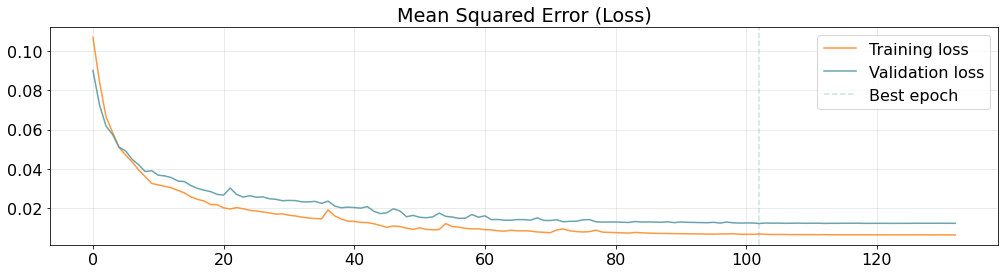

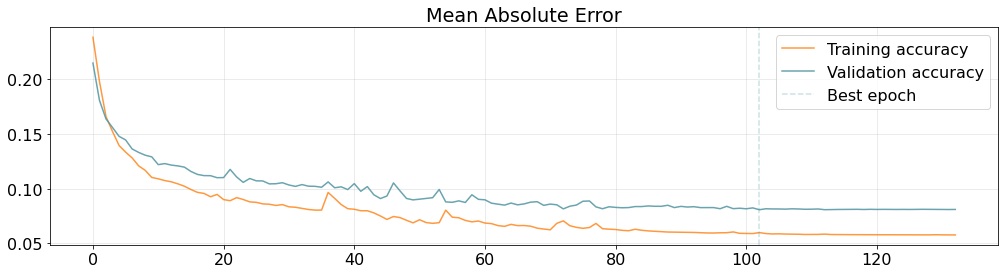

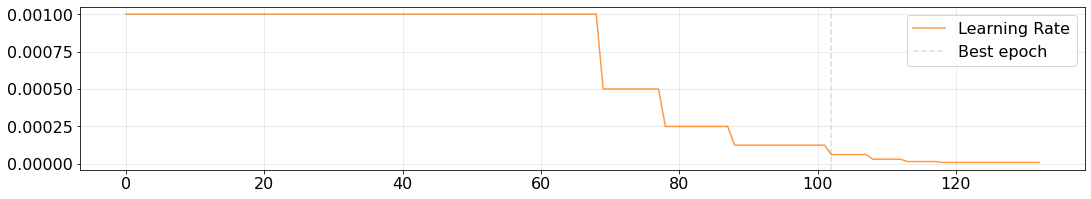

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
#model.save('Models/'+title+'_')
model = tfk.models.load_model('Models/'+title+'_')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
X_min = np.array([-0.972080, -8.450380, -34.802881, -9.028060, -1.275860, -6.006860, -38.816760])
X_max = np.array([15.106680, 18.122899, 41.138801, 14.035980, 6.056360, 77.371620, 31.024420])

predictions_full = predictions*(X_max-X_min)+X_min
y1 = y_test*(X_max-X_min)+X_min


mean_squared_error = tfk.metrics.mse(y1.flatten(),predictions_full.flatten())
mean_absolute_error = tfk.metrics.mae(y1.flatten(),predictions_full.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float64, numpy=34.1727839951087>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.6544874802581515>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

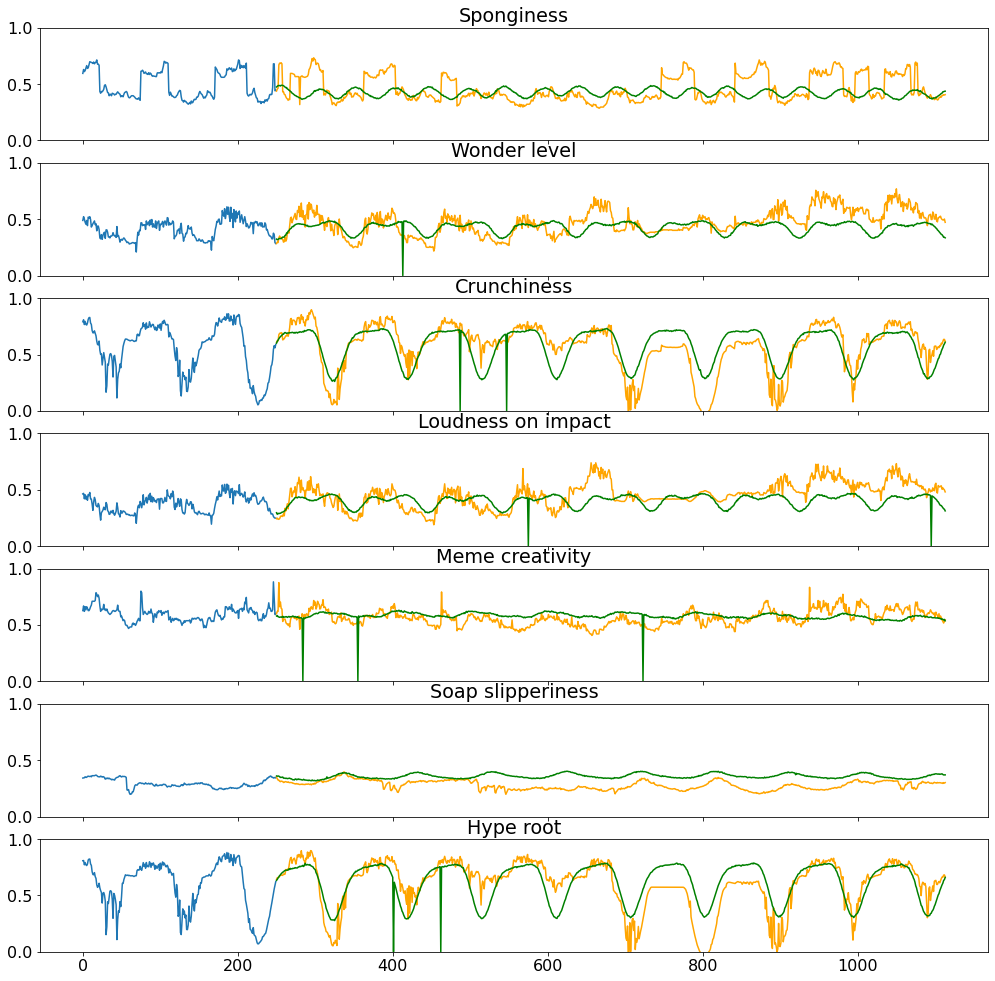

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)